In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets #interactive elements for jupytr
from ipywidgets import VBox, HBox #layout containers
from IPython.display import display  #displaying widgets
import scipy.stats as stats #statfunctions
from scipy.stats import gaussian_kde, linregress, pearsonr,spearmanr, ttest_rel, wilcoxon, shapiro
from datetime import datetime
from scipy.stats import shapiro
from matplotlib.ticker import MaxNLocator

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'

In [2]:
#load data from excel table
def load_table(file_path):
    df = pd.read_excel(file_path)
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r"[^a-z0-9]+", "_", regex=True)
        .str.replace(r"_+", "_", regex=True)
    )

    print("excel was loaded")

    required = [
        "cell", "drug", "stim",
        "dvdt_total", "dvdt_max", "dvdt_min",
        "amplitude", "halfwidth", "threshold",
        "number_of_peaks", "injection_to_threshold",
        "area"
    ]

    missing = [col for col in required if col not in df.columns]
    if missing:
        print("ERROR: missing:", missing)

    data = {col: df[col].tolist() for col in required}

    print("data was loaded")

    return df, data


In [3]:
df, data = load_table("/Users/csengi/Documents/CsengeR-CA3PC/Final_Data_Features.xlsx")
print(data["dvdt_total"][:3]) #check


excel was loaded
data was loaded
[3986.41797206002, 772.750639643145, 2339.9964815514]


In [4]:
#1D distributions
plt.rcParams.update({
    "font.family": "Avenir, Helvetica, DejaVu Sans",
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

excluded_cols = {"cell", "file_name"}
numeric_cols = [
    col for col in df.columns
    if col not in excluded_cols and pd.api.types.is_numeric_dtype(df[col])
]

drug_options = ["All"] + sorted(df["drug"].dropna().unique().tolist())

feature_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="Feature:",
    style={'description_width': '80px'},
    layout=widgets.Layout(width='300px')
)

drug_dropdown = widgets.Dropdown(
    options=drug_options,
    description="Drug:",
    style={'description_width': '80px'},
    layout=widgets.Layout(width='300px')
)

bins = widgets.IntSlider(
    value=30, min=5, max=200, step=5,
    description="Bins:",
    style={'description_width': '80px'},
    layout=widgets.Layout(width='300px')
)

output = widgets.Output()

def compute_stats(data):
    data = np.asarray(data)

    cv = np.std(data) / np.mean(data)
    if len(data) > 5000:
        sample = np.random.choice(data, size=5000, replace=False)
        stat, p = shapiro(sample)
    else:
        stat, p = shapiro(data)

    return cv, p

#updates when change
def update(change=None):
    with output:
        output.clear_output()

        feature = feature_dropdown.value
        selected_drug = drug_dropdown.value

        if selected_drug == "All":
            data = df[feature].dropna()
        else:
            data = df[df["drug"] == selected_drug][feature].dropna()

        if len(data) == 0:
            print(f"No data available for {selected_drug}.")
            return

        fig, ax = plt.subplots(figsize=(7, 5))

        #HISTOGRAM
        #ax.hist(data, bins=bins.value, color='#00bfff', alpha=0.45, density=True)

        #KDE CURVE FOR DENSITY
        # kde = gaussian_kde(data)
        # x_vals = np.linspace(min(data), max(data), 2000)
        # y_vals = kde(x_vals)

        # HISTOGRAM FOR COUNTS
        counts, edges, _ = ax.hist(
            data,
            bins=bins.value,
            color='plum',
            alpha=0.45
        )

        #KDE CURVE FOR COUNTS
        kde = gaussian_kde(data)
        x_vals = np.linspace(min(data), max(data), 2000)
        y_vals = kde(x_vals)

        #compute coefficent of variation
        cv, p_value = compute_stats(data)

        cv_text = f"CV = {cv:.3f}"
        p_text = f"Shapiro p = {p_value:.3g}"

        annotation = f"{cv_text}\n{p_text}"

        #plotting
        bin_width = edges[1] - edges[0]
        ax.plot(x_vals, y_vals * len(data) * bin_width, color='crimson', linewidth=2)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        title = f"{feature} distribution"
        if selected_drug != "All":
            title += f" — {selected_drug}"

        ax.set_title(title, pad=15)
        ax.set_xlabel(feature)
        # ax.set_ylabel("Density")
        ax.set_ylabel("Count")
        ax.grid(axis='y', alpha=0.2)

        print(f"Coefficient of Variation (CV): {cv:.4f}")
        print(f"Shapiro–Wilk p-value: {p_value:.4g}")
        #print(f"Outliers (modified z-score > 3.5): {num_outliers}")

        plt.tight_layout()
        plt.show()

feature_dropdown.observe(update, names="value")
drug_dropdown.observe(update, names="value")
bins.observe(update, names="value")

display(VBox([HBox([feature_dropdown, drug_dropdown]), bins, output]))
update()



In [12]:
#2D distributions
excluded_cols = {"cell", "file_name"}
numeric_cols = [
    col for col in df.columns
    if col not in excluded_cols and pd.api.types.is_numeric_dtype(df[col])
]
x_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="X axis:",
    layout=widgets.Layout(width="250px")
)

y_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="Y axis:",
    layout=widgets.Layout(width="250px")
)

bins = widgets.IntSlider(
    value=40, min=10, max=200, step=5,
    description="Bins:",
    layout=widgets.Layout(width="300px")
)

output = widgets.Output()

def update(*args):
    with output:
        output.clear_output()

        x = x_dropdown.value
        y = y_dropdown.value

        if x is None or y is None:
            print("Select both X and Y")
            return

        data = df[[x, y]].dropna()

        fig, ax = plt.subplots(figsize=(7, 6))
        hist = ax.hist2d(
            data[x], data[y],
            bins=bins.value,
            cmap="viridis"
        )

        plt.colorbar(hist[3], ax=ax, label="Density")
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(f"{x} vs {y}")

        plt.tight_layout()
        plt.show()

        corr = data[x].corr(data[y])
        print(f"correlation coefficient (pearson): {corr:.3f}")

x_dropdown.observe(update, names="value")
y_dropdown.observe(update, names="value")
bins.observe(update, names="value")
display(VBox([
    HBox([x_dropdown, y_dropdown]),bins, output]))

In [6]:
#select features to display
cols = [ "dvdt_total",
         #"dvdt_max", #dvdt well addressed in total
         #"dvdt_min",
         "amplitude",
         "halfwidth",
         "threshold",
         "number_of_peaks",
         #"injection_to_threshold",
         #"area"
        ]

In [7]:
pretty_names = {
    "dvdt_total": r"$\frac{dV}{dt}\ \text{Total}\ \left(\frac{\mathrm{mV}}{\mathrm{s}}\right)$",
    "amplitude": r"Amplitude ($\mathrm{mV}$)",
    "halfwidth": r"Half-Width ($\mathrm{s}$)",
    "threshold": r"Threshold ($\mathrm{mV}$)",
    "number_of_peaks": r"Number of Peaks",
    "injection_to_threshold": r"Injection $\rightarrow$ Threshold ($\mathrm{s}$)",
    "area" : r"Area ($\mathrm{mVs}$)"
}

In [8]:
#all 1D and 2D histograms
def distribution_comparer(df, cols, bins_1d=100, bins_2d=30, show_corr=False,save=False,filename="corner_plot", title="TTX1 Data Feature Distributions",):

    df = df.copy()
    df["drug"] = df["drug"].astype(str).str.strip().str.lower()
    df = df[df["drug"] == "ttx1"]

    n = len(cols)
    fig, axes = plt.subplots(n, n, figsize=(3.3 * n, 3.6 * n))
    plt.subplots_adjust(wspace=0.35, hspace=0.35)

    fig.suptitle(
    title,
    fontsize=32,
    fontweight="bold",
    y=0.94
    )

    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            if i == j:
                data = df[cols[i]].dropna()

                # Histogram as density
                ax.hist(
                    data,
                    bins=bins_1d,
                    density=True,
                    alpha=0.35,
                    color="thistle",
                    edgecolor="white"
                )

                kde = gaussian_kde(data)
                x_vals = np.linspace(data.min(), data.max(), 500)
                ax.plot(x_vals, kde(x_vals), color="crimson", linewidth=2)

                ax.locator_params(axis="x", nbins=5)
                ax.locator_params(axis="y", nbins=4)

                label = pretty_names.get(cols[i], cols[i])
                ax.set_xlabel(label, fontsize=14)

                #ax.set_ylabel("Density", fontsize=12)

            # 2d histogram
            elif j > i:
                d = df[[cols[j], cols[i]]].dropna()

                if len(d) > 0:
                    ax.hist2d(
                        d[cols[j]],
                        d[cols[i]],
                        bins=bins_2d,
                        cmap="viridis")
            else:
                if show_corr:
                    pair = df[[cols[j], cols[i]]].dropna()
                    if len(pair) > 5:
                        r, _ = pearsonr(pair[cols[j]], pair[cols[i]])
                        ax.text(
                            0.5, 0.5,
                            f"{r:.2f}",
                            ha="center", va="center",
                            fontsize=18, fontweight="bold"
                        )
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.spines["top"].set_visible(False)
                    ax.spines["right"].set_visible(False)

                else:
                    ax.axis("off")
                    continue

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

    if save:
        path = os.path.join("images", filename + ".png")
        fig.savefig(path, dpi=300, bbox_inches="tight")
        print("saved image")

    plt.show()


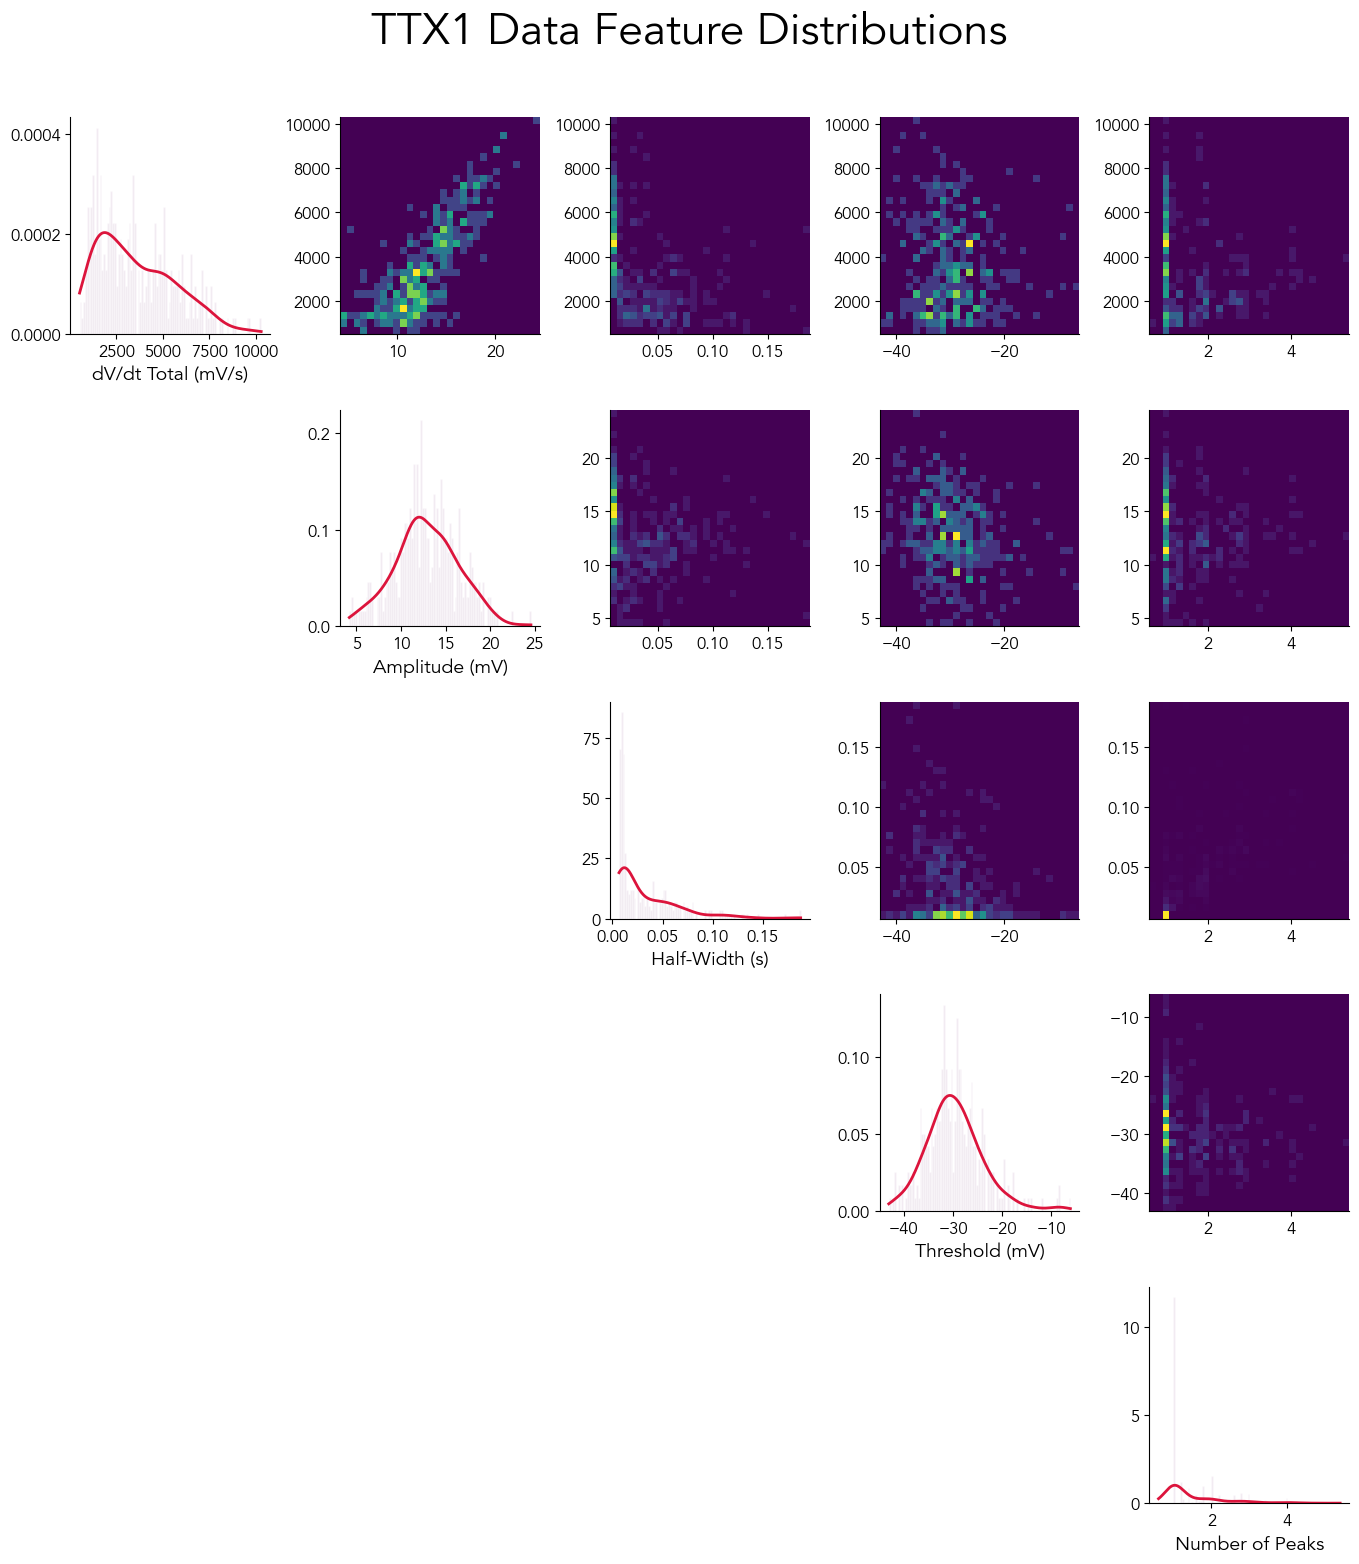

In [9]:
distribution_comparer(df, cols, save=False, filename="2D_histogram")

In [14]:
#scatter analysis between data features
excluded_cols = {"cell", "file_name"}
numeric_cols = [
    col for col in df.columns
    if col not in excluded_cols and pd.api.types.is_numeric_dtype(df[col])
]

drug_options = ["All"] + sorted(df["drug"].dropna().unique().tolist())

drug_dropdown = widgets.Dropdown(
    options=drug_options,
    description="Drug:",
    style={'description_width': '80px'},
    layout=widgets.Layout(width="300px")
)

x_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="X-axis:",
    style={'description_width': '80px'},
    layout=widgets.Layout(width="300px")
)

y_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="Y-axis:",
    style={'description_width': '80px'},
    layout=widgets.Layout(width="300px")
)

output_scatter = widgets.Output()

def update_scatter(change=None):
    with output_scatter:
        output_scatter.clear_output()

        selected_drug = drug_dropdown.value

        if selected_drug == "All":
            df_filtered = df.copy()
        else:
            df_filtered = df[df["drug"] == selected_drug]

        x = x_dropdown.value
        y = y_dropdown.value

        fig, ax = plt.subplots(figsize=(7, 6))

        ax.scatter(
            df_filtered[x], df_filtered[y],
            alpha=0.75, s=45,
            color='thistle', edgecolor='None'
        )

        x_vals = df_filtered[x].to_numpy()
        y_vals = df_filtered[y].to_numpy()

        # if len(x_vals) > 1:
        #     m, b = np.polyfit(x_vals, y_vals, 1)
        #     x_line = np.linspace(x_vals.min(), x_vals.max(), 200)
        #     y_line = m * x_line + b
        #     ax.plot(x_line, y_line, color='crimson', linewidth=2)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(alpha=0.2)
        ax.set_xlabel(x, fontsize=14)
        ax.set_ylabel(y, fontsize=14)
        ax.set_title(f"{x} vs {y} — {selected_drug}", fontsize=15)

        def padded_limits(series):
            low, high = np.min(series), np.max(series)
            pad = (high - low) * 0.05
            return low - pad, high + pad

        ax.set_xlim(*padded_limits(df_filtered[x]))
        ax.set_ylim(*padded_limits(df_filtered[y]))

        plt.tight_layout()
        plt.show()

        # pearson correlation
        # pearson_r = df_filtered[x].corr(df_filtered[y])

        #  coeff of determination
        # R2 = pearson_r ** 2

        # spearman rank correlation
        # spearman_rho, _ = spearmanr(df_filtered[x], df_filtered[y])

        # print(f"pearson correlation:           {pearson_r:.3f}")
        # print(f"coefficient of determination:  R² = {R2:.3f}")
        # print(f"spearman correlation:          {spearman_rho:.3f}")

for widget in (x_dropdown, y_dropdown, drug_dropdown):
    widget.observe(update_scatter, names="value")

display(VBox([HBox([x_dropdown, y_dropdown, drug_dropdown]), output_scatter]))

update_scatter()


In [48]:
ordered_cols = [
    "threshold", "dvdt_total", "halfwidth",
    "injection_to_threshold", "amplitude", "area",
]

def side_by_side_histograms(df, cols, bins_1d=100,
                             title="Density Distributions: Single-Peak vs Multi-Peak"):

    def safe_kde_plot(ax, data, color, linewidth=2):
        if len(data) > 1 and np.unique(data).size > 1:
            kde = gaussian_kde(data)
            x_vals = np.linspace(data.min(), data.max(), 500)
            ax.plot(x_vals, kde(x_vals), color=color, linewidth=linewidth)

    df = df.copy()
    df["drug"] = df["drug"].astype(str).str.strip().str.lower()
    df = df[df["drug"] == "ttx1"]

    df_single = df[df["number_of_peaks"] <= 1]
    df_multi  = df[df["number_of_peaks"] > 1]

    cols = [c for c in cols if c != "number_of_peaks"]

    cols = ordered_cols

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    fig.suptitle(title, fontsize=28, fontweight="regular", y=1.03)

    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for i, feature in enumerate(cols):
        ax = axes[i]

        data_multi = df_multi[feature].dropna()
        data_single = df_single[feature].dropna()

        # Histograms
        ax.hist(data_multi, bins=bins_1d, density=True,
                alpha=0.35, color="royalblue", edgecolor="white")
        # ax.hist(data_multi, bins=bins_1d, density=True,
        #         alpha=0.35, color="limegreen", edgecolor="white")
        ax.hist(data_single, bins=bins_1d, density=True,
                alpha=0.35, color="mediumvioletred", edgecolor="white")

        # KDE
        safe_kde_plot(ax, data_multi, "royalblue")
        # safe_kde_plot(ax, data_multi, "limegreen")
        safe_kde_plot(ax, data_single, "mediumvioletred")

        ax.set_xlabel(pretty_names.get(feature, feature), fontsize=16)
        ax.set_yticklabels([])
        ax.tick_params(axis="y", length=0)


        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        if i == 2:
            ax.legend(["Multi-Peaks", "Single-Peak"],
                      frameon=False, fontsize=14)

    plt.show()
    return fig


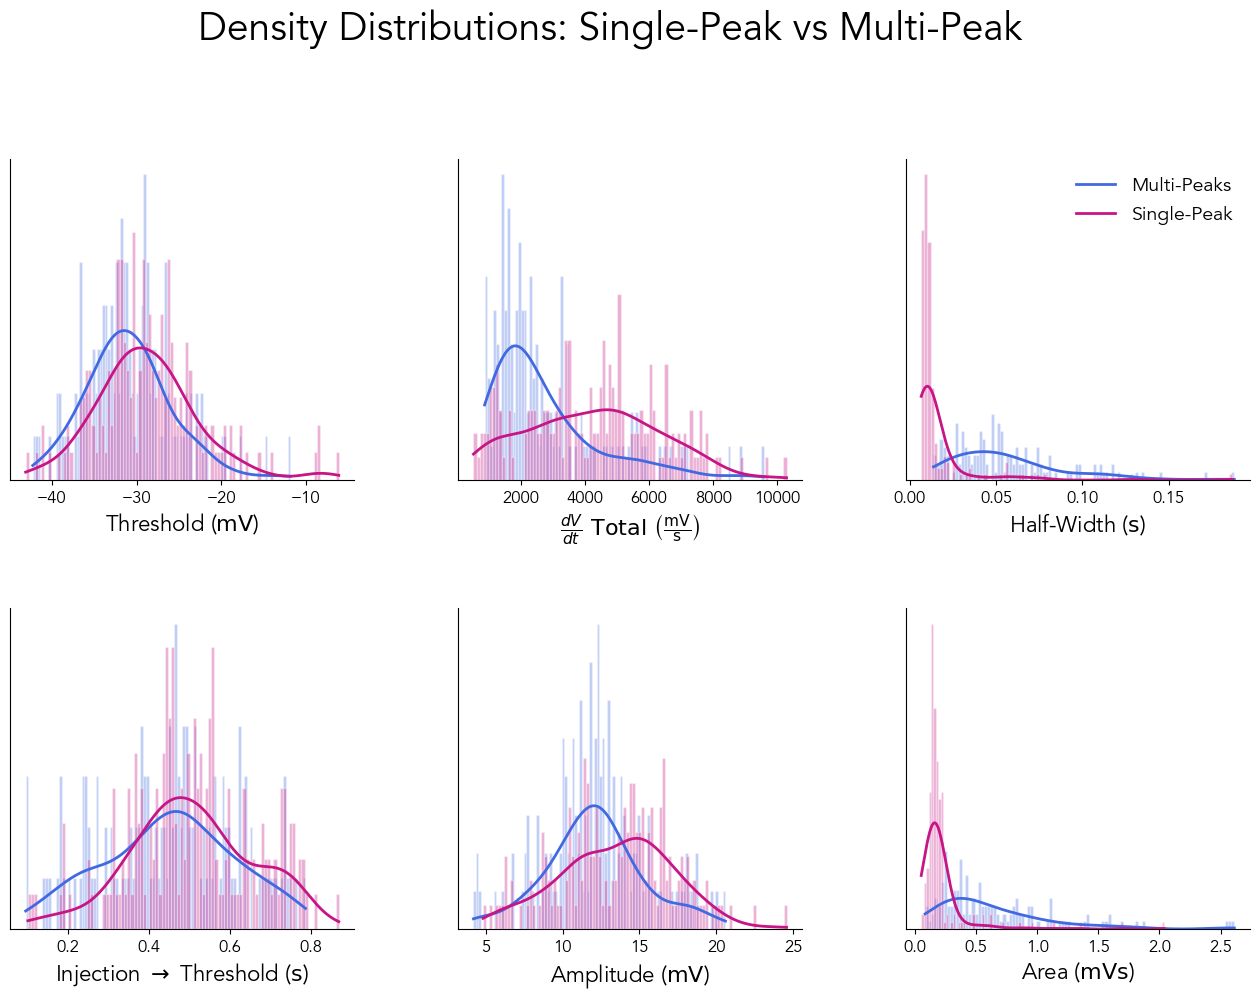

In [49]:
fig = side_by_side_histograms(df, ordered_cols)
fig.savefig("images/new/histograms.svg", format="svg")

In [15]:
def compute_stats(data):
    data = np.asarray(data)

    # Coefficient of variation
    cv = np.std(data) / np.mean(data)

    # Shapiro–Wilk normality test
    # (Shapiro cannot run with extremely large N, so we subsample)
    if len(data) > 5000:
        sample = np.random.choice(data, size=5000, replace=False)
        stat, p = shapiro(sample)
    else:
        stat, p = shapiro(data)

    return cv, p

def all_scatters(df, cols, bins_1d=100,
        corr_mode="none",
        save=False, filename="corner_scatter_plot",
        title="Pairwise Relationships Between Spike Features"):

    df = df.copy()
    df["drug"] = df["drug"].astype(str).str.strip().str.lower()
    df = df[df["drug"] == "ttx1"]

    n = len(cols)
    fig, axes = plt.subplots(n, n, figsize=(3.3 * n, 3.6 * n))
    plt.subplots_adjust(wspace=0.35, hspace=0.35)

    fig.suptitle(title, fontsize=32, fontweight="normal", y=0.94)

    for i in range(n):
        for j in range(n):
            ax = axes[i, j]

            # =====================================================
            # 1) DIAGONAL: 1D HISTOGRAM WITH CV & p-values
            # =====================================================
            if i == j:
                feature = cols[i]
                data = df[feature].dropna()

                ax.hist(
                    data,
                    bins=bins_1d,
                    density=True,
                    alpha=0.35,
                    #color="thistle",
                    color="royalblue",
                    edgecolor="white"
                )

                kde = gaussian_kde(data)
                x_vals = np.linspace(data.min(), data.max(), 500)
                ax.plot(x_vals, kde(x_vals), color="crimson", linewidth=2)

                # --- NEW: compute CV and p-value ---
                cv, p_value = compute_stats(data)

                # --- NEW: add text inside histogram ---
                ax.text(
                    0.98, 0.95,
                    f"CV = {cv:.2f}\np = {p_value:.2e}",
                    ha="right", va="top",
                    fontsize=12,
                    transform=ax.transAxes,
                    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
                )

                label = pretty_names.get(feature, feature)
                ax.set_xlabel(label)
                ax.xaxis.label.set_fontsize(16)
                ax.xaxis.label.set_fontweight('medium')
                ax.locator_params(axis="x", nbins=5)
                ax.locator_params(axis="y", nbins=4)

            # =====================================================
            # 2) UPPER RIGHT: SCATTER WITH LINE + r IN TOP-RIGHT
            # =====================================================
            elif j > i:
                f_x = cols[j]
                f_y = cols[i]
                d = df[[f_x, f_y]].dropna()

                if len(d) > 1:
                    ax.scatter(
                        d[f_x], d[f_y],
                        s=18, alpha=0.35,
                        #color="thistle", edgecolor="none"
                        color="royalblue", edgecolor="none"
                    )

                    # Pearson correlation
                    r = d[f_x].corr(d[f_y])

                    # --- r value in upper right corner ---
                    ax.text(
                        0.98, 0.98,
                        f"r = {r:.2f}",
                        ha="right", va="top",
                        fontsize=12, fontweight="normal",
                        transform=ax.transAxes,
                        #bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
                        #bbox=None
                    )

                else:
                    ax.text(0.5, 0.5, "no data",
                            ha="center", va="center", fontsize=10)


            # =====================================================
            # 3) LOWER LEFT: 2D HISTOGRAM (mirrors upper-right)
            # =====================================================
            else:   # j < i
                d = df[[cols[j], cols[i]]].dropna()

                if len(d) > 0:
                    # Draw 2D histogram
                    h = ax.hist2d(
                        d[cols[j]],
                        d[cols[i]],
                        bins=30,
                        cmap="viridis"
                    )

                else:
                    ax.axis("off")
                    continue

                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)



    if save:
        path = os.path.join("images", filename + ".png")
        fig.savefig(path, dpi=300, bbox_inches="tight")
        print("saved image")

    plt.show()
    return fig


FileNotFoundError: [Errno 2] No such file or directory: 'images/scatter_analysis_between_DFs.png'

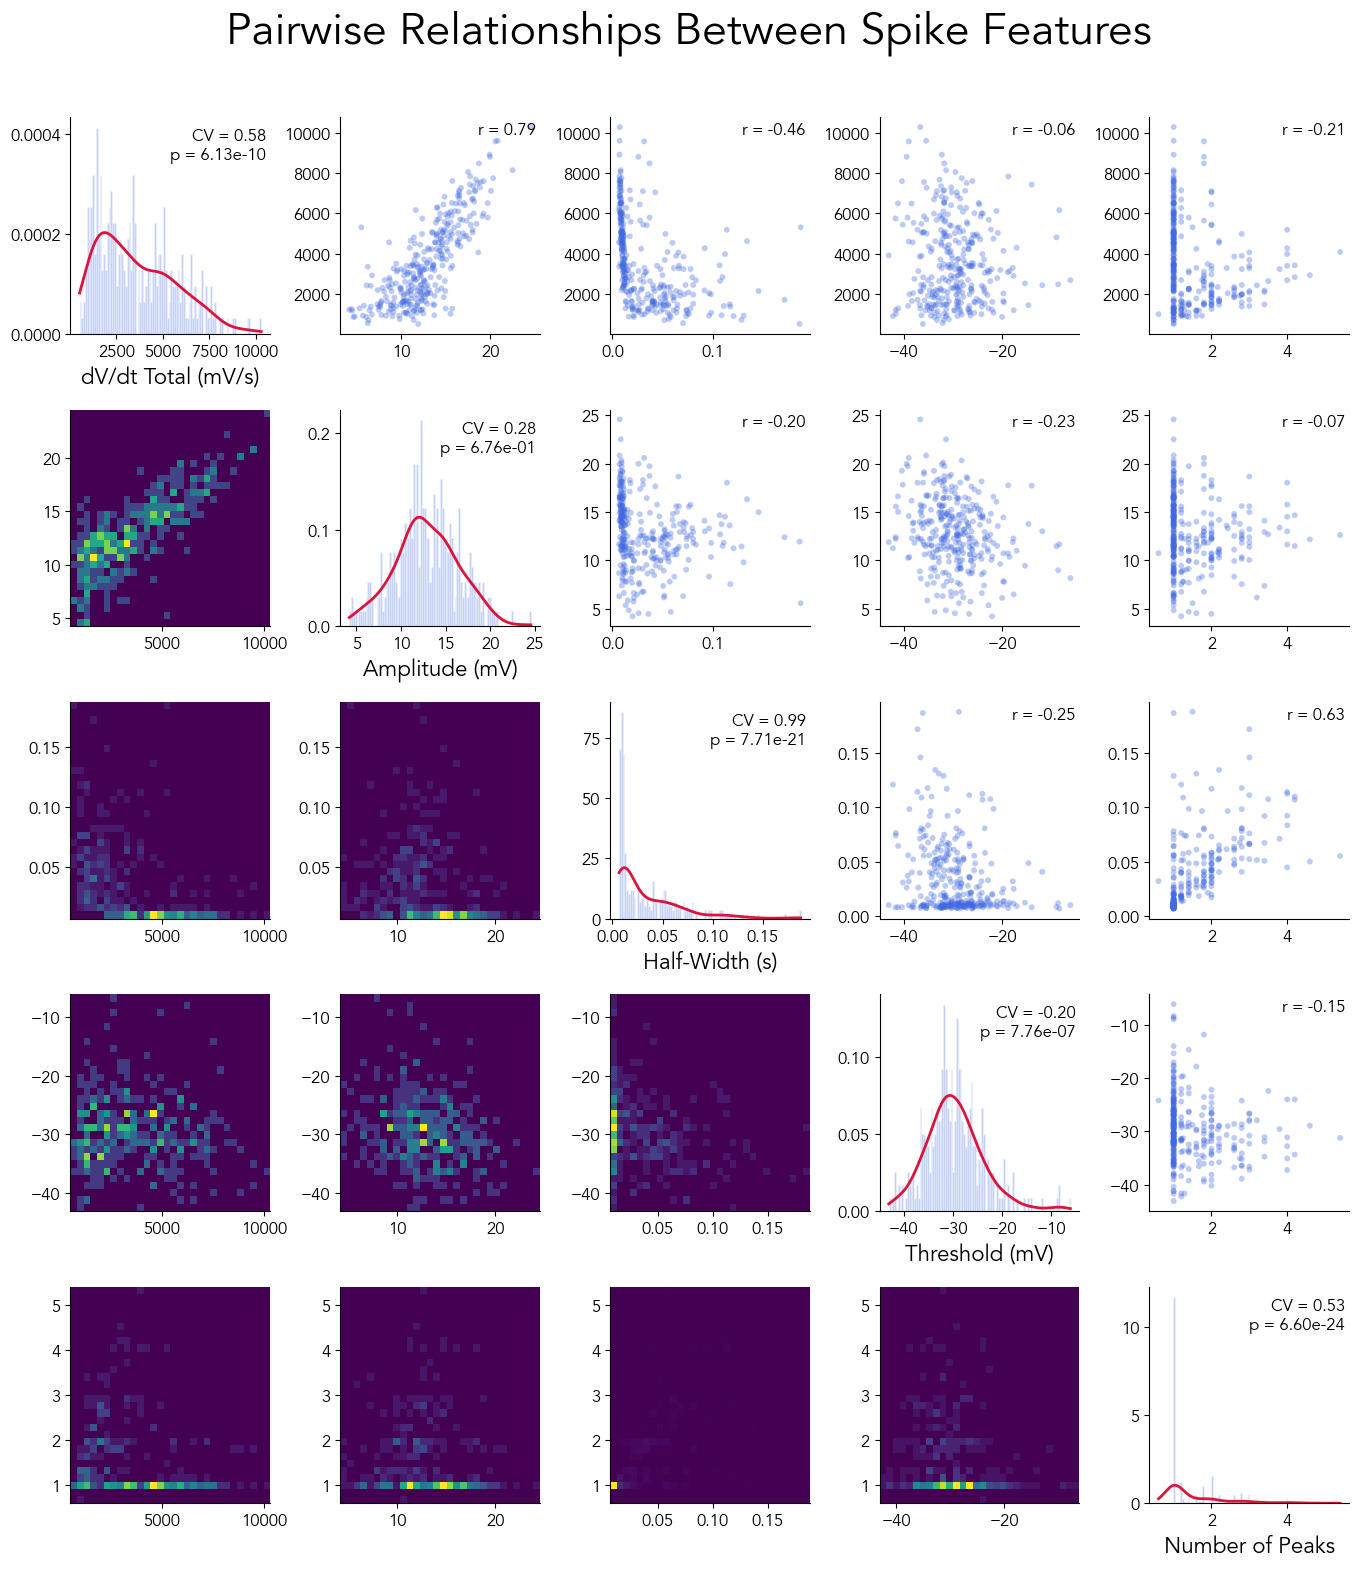

In [16]:
fig = all_scatters(df, cols, corr_mode="full", save=False, filename="scatter_analysis_between_DFs")
# fig.savefig("images/svg/pairwise_relationships.svg", format="svg")

In [17]:
def plot_all_drug_comparisons(df, metric, show=True):

    df = df.copy()
    df["drug"] = df["drug"].astype(str).str.strip()

    drugs_to_plot = [ #drugs that could be worth plotting - enough data points (in my humble opinion)
        # "4AP",
        # "CCh2",
        # "Mibefradil",
        # "TEAC",
        # "XE+AmmTx",
        # "bromides",
        # "retigabine"

        #drugs that they looked at in the article
        "ap+ib",
        "GxTx",
        "AmmTx2",
        #"CTX", #very small effect
        # "DTX", #few data points
        # "SNX", #doesnt reall do anything
        # "TTAP2",
        "XE",
        # "nicl100", #these stuff are triv i guess
        # "nimo10",
        # "nimo20",
    ]

    ttx1 = df[df["drug"].str.upper() == "TTX1"]

    n = len(drugs_to_plot)
    fig, axes = plt.subplots(1, n, figsize=(2.6 * n, 5), sharey=True)
    plt.subplots_adjust(wspace=0.4)

    #stats
    stats_output = []

    for ax, drug in zip(axes, drugs_to_plot):

        other = df[df["drug"] == drug]

        paired = ttx1.merge(other, on="cell", suffixes=("_ttx1", "_drug"))

        if paired.empty:
            ax.set_title(drug)
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
            ax.set_xticks([])
            continue

        y1 = paired[f"{metric}_ttx1"].to_numpy()
        y2 = paired[f"{metric}_drug"].to_numpy()

        delta = y2 - y1
        n_pairs = len(delta)
        mean_delta = delta.mean()

        stats_output.append(
            f"{drug}\n"
            f"  n = {n_pairs}\n"
            f"  mean Δ = {mean_delta:+.3f}\n"
            f"{'-'*35}"
        )

        x_ctr = 0.1
        x_inh = 0.9
        ax.set_xlim(0, 1)

        for a, b in zip(y1, y2):
            ax.plot([x_ctr, x_inh], [a, b], color="gray", alpha=0.5, linewidth=1.5, zorder=1)

        ax.scatter(np.full_like(y1, x_ctr), y1, color="plum", s=55, edgecolor="none", zorder=3)
        ax.scatter(np.full_like(y2, x_inh), y2, color="limegreen", s=55, edgecolor="none", zorder=3)

        #ERROR BARS
        m1, m2 = np.mean(y1), np.mean(y2)
        e1 = np.std(y1) / np.sqrt(len(y1)) #std deviation/ square root number of points
        e2 = np.std(y2) / np.sqrt(len(y2))

        ax.errorbar(x_ctr, m1, yerr=e1, fmt='o', color="navy", capsize=5, zorder=4)
        ax.errorbar(x_inh, m2, yerr=e2, fmt='o', color="navy", capsize=5, zorder=4)
        ax.plot([x_ctr, x_inh], [m1, m2], color="navy", linewidth=3, zorder=3)

        display_name = "IbTx+Ap" if drug == "ap+ib" else drug
        ax.set_title(display_name, fontsize=20, pad=10)
        ax.set_xticks([x_ctr, x_inh])
        ax.set_xticklabels(["ctr.", "inh."], fontsize=24)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", alpha=0.2)

        ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.tick_params(axis="y", labelsize=18, width=2, length=6)
        ax.tick_params(axis="x", labelsize=18, width=2, length=6)


        for spine in ["left", "bottom"]:
            ax.spines[spine].set_linewidth(2.5)

    fig.supylabel(pretty_names.get(metric, metric), fontsize=26)

    if show:
        plt.show()

    return fig, stats_output


metric_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="Feature:",
    layout=widgets.Layout(width="300px")
)

save_button = widgets.Button(
    description="Save figure",
    button_style='',
    layout=widgets.Layout(width="150px")
)

output_drug = widgets.Output()

def update_drug(change=None):
    with output_drug:
        output_drug.clear_output()
        fig, stats_out = plot_all_drug_comparisons(df, metric_dropdown.value)
        print("\n".join(stats_out))

def save_plot(b):
    feature = metric_dropdown.value
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"1d affect - {feature} - {timestamp}.svg"
    filepath = os.path.join("images/new", filename)

    plt.close('all')
    fig, _ = plot_all_drug_comparisons(df, feature, show=False)

    fig.savefig(filepath, format="svg", dpi=300, bbox_inches="tight")

    print(f"Saved: {filepath}")

save_button.on_click(save_plot)
metric_dropdown.observe(update_drug, names="value")

display(VBox([metric_dropdown, save_button, output_drug]))

update_drug()


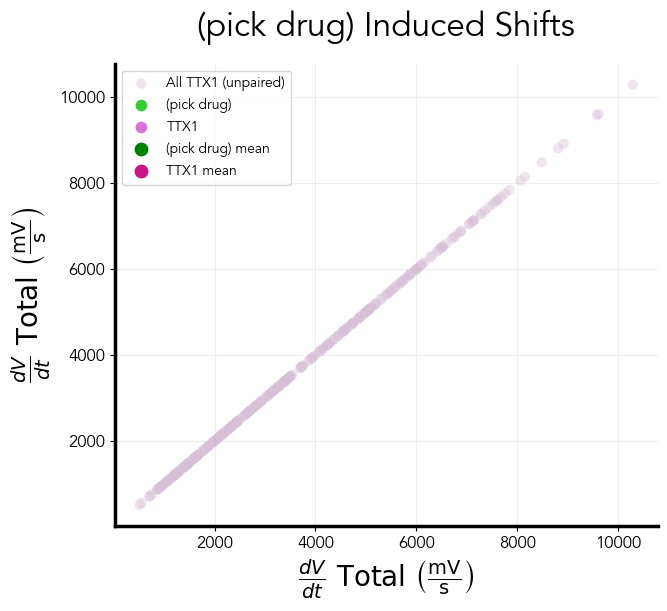

In [59]:
#2d affect of drugs
excluded_cols = {"cell", "file_name"}
numeric_cols = [
    col for col in df.columns
    if col not in excluded_cols and pd.api.types.is_numeric_dtype(df[col])
]

all_drugs = sorted(df["drug"].dropna().unique().tolist())
drugs_except_ttx1 = [d for d in all_drugs if d.upper() != "TTX1"]

x_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="X-axis:",
    style={'description_width': '70px'},
    layout=widgets.Layout(width="260px")
)

y_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="Y-axis:",
    style={'description_width': '70px'},
    layout=widgets.Layout(width="260px")
)

drug_dropdown = widgets.Dropdown(
    options=["(pick drug)"] + drugs_except_ttx1,
    description="Drug:",
    style={'description_width': '70px'},
    layout=widgets.Layout(width="260px")
)

save_button = widgets.Button(
    description="Save plot",
    layout=widgets.Layout(width="150px")
)

output_scatter = widgets.Output()

def plot_shift():
    drug2 = drug_dropdown.value
    x = x_dropdown.value
    y = y_dropdown.value

    ttx = df[df["drug"].str.upper() == "TTX1"].copy()

    other = df[df["drug"] == drug2].copy()

    paired = ttx.merge(other, on="cell", suffixes=("_ttx1", "_other"))

    fig, ax = plt.subplots(figsize=(7, 6))

    ax.scatter(
        ttx[x], ttx[y],
        #color="royalblue", s=45, alpha=0.4,
        color="thistle", s=55, alpha=0.4,
        edgecolor="none", label="All TTX1 (unpaired)",
        zorder=0
    )


    for _, row in paired.iterrows():
        ax.plot(
            [row[f"{x}_ttx1"], row[f"{x}_other"]],
            [row[f"{y}_ttx1"], row[f"{y}_other"]],
            color="lightgray", linewidth=2, alpha=0.6, zorder=1
        )

    mean_x_ttx1 = paired[f"{x}_ttx1"].mean()
    mean_y_ttx1 = paired[f"{y}_ttx1"].mean()
    mean_x_other = paired[f"{x}_other"].mean()
    mean_y_other = paired[f"{y}_other"].mean()

    ax.annotate(
        "",
        xy=(mean_x_other, mean_y_other),
        xytext=(mean_x_ttx1, mean_y_ttx1),
        arrowprops=dict(arrowstyle="->", color="black", lw=2, alpha=0.9),
        zorder=7
    )

    ax.scatter(
        paired[f"{x}_other"], paired[f"{y}_other"],
        color="limegreen", s=70, edgecolor="None", label=drug2, zorder=2
    )
    ax.scatter(
        paired[f"{x}_ttx1"], paired[f"{y}_ttx1"],
        #color="royalblue", s=70, edgecolor="None", label="TTX1", zorder=3
        #color="thistle", s=70, edgecolor="None", label="TTX1", zorder=3
        color="orchid", s=70, edgecolor="None", label="TTX1", zorder=3
    )

    ax.scatter(
        mean_x_other, mean_y_other,
        color="green", s=80, zorder=8, label=f"{drug2} mean"
    )
    ax.scatter(
        mean_x_ttx1, mean_y_ttx1,
        color="mediumvioletred", s=80, zorder=9, label="TTX1 mean"
        #color="navy", s=80, zorder=9, label="TTX1 mean"
    )

    ax.set_xlabel(pretty_names.get(x, x), fontsize=20)
    ax.set_ylabel(pretty_names.get(y, y), fontsize=20)
    ax.set_title(f"{drug2} Induced Shifts", fontsize=24, fontweight= 'regular', pad=20)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(alpha=0.2)
    ax.legend()
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

    def padded(series):
        low, high = np.min(series), np.max(series)
        return low - (high - low) * 0.05, high + (high - low) * 0.05

    ax.set_xlim(*padded(np.concatenate([paired[f"{x}_ttx1"], paired[f"{x}_other"]])))
    ax.set_ylim(*padded(np.concatenate([paired[f"{y}_ttx1"], paired[f"{y}_other"]])))

    plt.tight_layout()
    return fig


def update_scatter(change=None):
    with output_scatter:
        output_scatter.clear_output()
        fig = plot_shift()
        if fig is not None:
            plt.show()

def save_plot(b):
    fig = plot_shift()
    if fig is None:
        print("Nothing to save.")
        return

    feature_x = x_dropdown.value
    feature_y = y_dropdown.value
    drug2 = drug_dropdown.value
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    filename = f"2D affect - {drug2} - {feature_x} vs {feature_y} - {timestamp}.svg"
    filepath = os.path.join("images/svg/specific_drug_effects/AmmTx2", filename)

    fig.savefig(filepath, format="svg")

    print(f"Saved: {filename}")


save_button.on_click(save_plot)

x_dropdown.observe(update_scatter, names="value")
y_dropdown.observe(update_scatter, names="value")
drug_dropdown.observe(update_scatter, names="value")

display(VBox([
    HBox([x_dropdown, y_dropdown, drug_dropdown, save_button]),
    output_scatter
]))

update_scatter()


In [19]:
excluded_cols = {"cell", "file_name"}

numeric_cols = [
    col for col in df.columns
    if col not in excluded_cols and pd.api.types.is_numeric_dtype(df[col])
]

all_drugs = sorted(df["drug"].dropna().unique().tolist())
drugs_except_ttx1 = [d for d in all_drugs if d.upper() != "TTX1"]

x_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="X-axis:",
    style={'description_width': '70px'},
    layout=widgets.Layout(width="260px")
)

y_dropdown = widgets.Dropdown(
    options=numeric_cols,
    description="Y-axis:",
    style={'description_width': '70px'},
    layout=widgets.Layout(width="260px")
)

drug_dropdown = widgets.Dropdown(
    options=["(pick drug)"] + drugs_except_ttx1,
    description="Drug:",
    style={'description_width': '70px'},
    layout=widgets.Layout(width="260px")
)

save_button = widgets.Button(
    description="Save plot",
    layout=widgets.Layout(width="150px")
)

output_scatter = widgets.Output()


def padded_max(series1, series2, pad_ratio=0.05):
    combined = np.concatenate([series1, series2])

    min_val = np.nanmin(combined)
    max_val = np.nanmax(combined)

    span = max_val - min_val
    pad = span * pad_ratio if span != 0 else 1


    if min_val > 0:
        min_val = max(0, min_val)

    return min_val - pad, max_val + pad


def plot_shift():
    drug2 = drug_dropdown.value
    x = x_dropdown.value
    y = y_dropdown.value

    if drug2 == "(pick drug)":
        return None
    ttx = df[df["drug"].str.upper() == "TTX1"].copy()
    other = df[df["drug"] == drug2].copy()

    paired = ttx.merge(other, on="cell", suffixes=("_ttx1", "_other"))

    if paired.empty:
        print(f"No paired cells found for {drug2}.")
        return None

    fig, ax = plt.subplots(figsize=(7, 6))

    ax.scatter(
        ttx[x], ttx[y],
        color="thistle",
        s=55,
        alpha=0.4,
        edgecolor="none",
        label="All TTX1 (unpaired)",
        zorder=0
    )

    for _, row in paired.iterrows():
        ax.plot(
            [row[f"{x}_ttx1"], row[f"{x}_other"]],
            [row[f"{y}_ttx1"], row[f"{y}_other"]],
            color="lightgray",
            linewidth=2,
            alpha=0.6,
            zorder=1
        )

    mean_x_ttx1 = paired[f"{x}_ttx1"].mean()
    mean_y_ttx1 = paired[f"{y}_ttx1"].mean()
    mean_x_other = paired[f"{x}_other"].mean()
    mean_y_other = paired[f"{y}_other"].mean()

    ax.annotate(
        "",
        xy=(mean_x_other, mean_y_other),
        xytext=(mean_x_ttx1, mean_y_ttx1),
        arrowprops=dict(
            arrowstyle="->",
            color="black",
            lw=2,
            alpha=0.9
        ),
        zorder=7
    )

    ax.scatter(
        paired[f"{x}_other"], paired[f"{y}_other"],
        color="limegreen",
        s=70,
        edgecolor="none",
        #label=drug2,
        label = "IbTx + Ap",
        zorder=3
    )

    ax.scatter(
        paired[f"{x}_ttx1"], paired[f"{y}_ttx1"],
        color="orchid",
        s=70,
        edgecolor="none",
        label="TTX1 (paired)",
        zorder=4
    )

    ax.scatter(
        mean_x_other,
        mean_y_other,
        color="green",
        s=80,
        zorder=8,
        label = f"TTX1 + {drug2}"
    )

    ax.scatter(
        mean_x_ttx1,
        mean_y_ttx1,
        color="mediumvioletred",
        s=80,
        zorder=9,
        label="TTX1 mean"
    )

    ax.set_xlabel(pretty_names.get(x, x), fontsize=20)
    ax.set_ylabel(pretty_names.get(y, y), fontsize=20)
    ax.set_title(f"{drug2} Induced Shifts", fontsize=24, pad=20)

    if x.lower() not in ["number of peaks", "peak count", "num_peaks"]:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

    if y.lower() not in ["number of peaks", "peak count", "num_peaks"]:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    ax.tick_params(axis="both", which="major", labelsize=16, width=2, length=7)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(alpha=0.2)
    ax.legend()

    for spine in ax.spines.values():
        spine.set_linewidth(2.5)


    xmin, xmax = padded_max(ttx[x].values, other[x].values)
    ymin, ymax = padded_max(ttx[y].values, other[y].values)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    plt.tight_layout()
    return fig

def update_scatter(change=None):
    with output_scatter:
        output_scatter.clear_output()
        fig = plot_shift()
        if fig is not None:
            plt.show()

def save_plot(b):
    fig = plot_shift()
    if fig is None:
        print("Nothing to save.")
        return

    feature_x = x_dropdown.value
    feature_y = y_dropdown.value
    drug2 = drug_dropdown.value
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    filename = f"2D affect - {drug2} - {feature_x} vs {feature_y} - {timestamp}.svg"
    filepath = os.path.join("images/new", filename)

    fig.savefig(filepath, format="svg")
    print(f"Saved: {filename}")


save_button.on_click(save_plot)
x_dropdown.observe(update_scatter, names="value")
y_dropdown.observe(update_scatter, names="value")
drug_dropdown.observe(update_scatter, names="value")

display(VBox([
    HBox([x_dropdown, y_dropdown, drug_dropdown, save_button]),
    output_scatter
]))

update_scatter()



In [ ]:
# START OF PCA ANALYSIS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
features = cols


In [ ]:
data_TTX = df[df["drug"].astype(str).str.strip().str.lower() == "ttx1"]
X = data_TTX[features].values #onlywant those data features

# standardize
scaler = StandardScaler()
scaler.fit(X) # learn mean and sd from each feature
X_scaled = scaler.transform(X) # apply transformation (z-score normalization: x_scaled = x - mean / sd)

print(X_scaled.shape)
print(X_scaled[:3])

In [ ]:
# pca
pca = PCA()
X_pca = pca.fit_transform(X_scaled) #actually learns the PCA structure
#x_pca = x_scaled*V where V = matrix of principal components

In [ ]:
# explained variance
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(features)+1),
         pca.explained_variance_ratio_ * 100,
         marker='o')
plt.xlabel("Principal Component")
plt.ylabel("% Variance it Explains")
plt.show()

In [ ]:
pc1 = X_pca[:,0]
pc2 = X_pca[:,1]
pc3 = X_pca[:,2]

plt.figure(figsize=(7,6))
plt.scatter(pc1, pc2, alpha=0.5)

# feature loading vectors
for i, feature in enumerate(features):
    plt.arrow(0, 0,
              pca.components_[0, i] * 2,
              pca.components_[1, i] * 2,
              head_width=0.05,
              color='red')
    plt.text(pca.components_[0, i] * 2.2,
             pca.components_[1, i] * 2.2,
             feature, color='red')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [ ]:
cmap = plt.colormaps['viridis']

def normalize(v):
    v = np.asarray(v)
    v = v - v.min()
    v = v / v.max()
    return v

loghw_raw = X[:, 2]
dVdtt_raw = X[:, 0]
th_raw = X[:, 3]

loghw_norm = normalize(loghw_raw)
dVdtt_norm = normalize(dVdtt_raw)
th_norm = normalize(th_raw)

def colored_hist(ax, raw_values, title, bins=50):
    counts, bin_edges = np.histogram(raw_values, bins=bins)
    centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    colors = cmap(normalize(centers))

    ax.bar(bin_edges[:-1], counts, width=np.diff(bin_edges),
           color=colors, align='edge')

    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Value", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)

    ax.tick_params(axis='both', labelsize=18, width=3, length=7)
    for spine in ax.spines.values():
        spine.set_linewidth(3)

fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], wspace=0.3, hspace=0.35)

ax_p1 = fig.add_subplot(gs[0, 0])
ax_p2 = fig.add_subplot(gs[0, 1])
ax_p3 = fig.add_subplot(gs[0, 2])

ax_h1 = fig.add_subplot(gs[1, 0])
ax_h2 = fig.add_subplot(gs[1, 1])
ax_h3 = fig.add_subplot(gs[1, 2])

lim = max(np.abs(pc1).max(), np.abs(pc2).max())

def style_pca_axis(ax, title):
    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("PC1", fontsize=18)
    ax.set_ylabel("PC2", fontsize=18)

    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal')

    ax.tick_params(axis='both', labelsize=18, width=3, length=7)
    for spine in ax.spines.values():
        spine.set_linewidth(3)

sc1 = ax_p1.scatter(pc1, pc2, c=loghw_norm, cmap=cmap, s=55, edgecolor='none')
sc2 = ax_p2.scatter(pc1, pc2, c=dVdtt_norm, cmap=cmap, s=55, edgecolor='none')
sc3 = ax_p3.scatter(pc1, pc2, c=th_norm, cmap=cmap, s=55, edgecolor='none')

style_pca_axis(ax_p1, "PCA Colored by log(hw)")
style_pca_axis(ax_p2, "PCA Colored by dV/dt")
style_pca_axis(ax_p3, "PCA Colored by Threshold")

colored_hist(ax_h1, loghw_raw, "Histogram: log(hw)")
colored_hist(ax_h2, dVdtt_raw, "Histogram: dV/dt")
colored_hist(ax_h3, th_raw, "Histogram: Threshold")

cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
cbar = fig.colorbar(sc3, cax=cbar_ax)
cbar.set_label("Normalized Feature Value", fontsize=18)

cbar.ax.tick_params(labelsize=18, width=3, length=7)
for spine in cbar.ax.spines.values():
    spine.set_linewidth(3)

plt.tight_layout(rect=[0, 0, 0.9, 1])
fig.savefig("images_new/pca_hist_2x3.svg", format="svg", dpi=300, bbox_inches="tight")

plt.show()